In [136]:
import pandas as pd
import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from lofo import LOFOImportance, plot_importance, Dataset
import lightgbm as lgbm
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import optuna
from IPython.core.display import HTML
import dataframe_image as dfi
from sklearn.metrics import mutual_info_score
import seaborn as sns
# pd.options.display.float_format = '{:,.3f}'.format

In [4]:
train_in = pd.read_csv('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/data/application_train.csv')
test_in = pd.read_csv('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/data/application_test.csv')
print('Train set shape: ', train_in.shape)
print('Test set shape: ', test_in.shape)
train_in.columns = train_in.columns.str.lower()
test_in.columns = test_in.columns.str.lower()

Train set shape:  (307511, 122)
Test set shape:  (48744, 121)


In [71]:
print(train_in.columns)
print([x for x in train_in.columns if x not in test_in.columns])
d_types = train_in.dtypes

Index(['sk_id_curr', 'target', 'name_contract_type', 'code_gender',
       'flag_own_car', 'flag_own_realty', 'cnt_children', 'amt_income_total',
       'amt_credit', 'amt_annuity',
       ...
       'flag_document_18', 'flag_document_19', 'flag_document_20',
       'flag_document_21', 'amt_req_credit_bureau_hour',
       'amt_req_credit_bureau_day', 'amt_req_credit_bureau_week',
       'amt_req_credit_bureau_mon', 'amt_req_credit_bureau_qrt',
       'amt_req_credit_bureau_year'],
      dtype='object', length=122)
['target']


In [6]:
# inspections.score.describe()
# def test_dependency(df, col1, col2):
#     '''Tests whether there is total redundancy betwen col1 and col2
#        by testing the number of unique combinations'''
#     unique_1 = len(df[col1].unique())
#     unique_2 = len(df[col2].unique())
#     unique_combos = len(df[[col1, col2]].drop_duplicates())
#     if unique_1 == 2 and unique_2 == 2:
#         if list(sorted(df[col1].unique())) == [0, 1] and unique_combos == max(unique_1, unique_2):
#             print("Unique combos of {} and {}: {}".format(col1, col2, unique_combos))

# for col1 in train_in.columns:
#     for col2 in train_in.columns:
#         if col2 == col1 or col1 in ['sk_id_curr', 'target'] or col2 in ['sk_id_curr', 'target']:
#             continue
#         test_dependency(train_in, col1, col2)

In [7]:
unique_cols = [i for i in train_in.columns if i not in test_in.columns]
unique_cols

['target']

In [8]:
# Test if these variables are a unique identifier
possible_identifier = ['sk_id_curr']
print("# of duplicates: ",sum(train_in.duplicated(possible_identifier)))

# of duplicates:  0


In [102]:
for col in train_in.columns:
    if len(train_in[col].unique()) > 10:
        temp = train_in.copy()
        temp['count'] = temp.groupby(col)['sk_id_curr'].transform('count')
        temp['percentage'] = temp['count'] / len(temp)
        if temp['percentage'].max() > 0.15:
            print('{}: {}, {:,}, {:.1%}'.format(col, temp[temp['percentage'] > 0.15].reset_index().loc[0][col], temp[temp['percentage'] > 0.15].reset_index().loc[0]['count'], temp[temp['percentage'] > 0.15].reset_index().loc[0]['percentage']))

cnt_children: 0, 215,371, 70.0%
days_employed: 365243, 55,374, 18.0%
occupation_type: Laborers, 55,186.0, 17.9%
cnt_fam_members: 1.0, 67,847.0, 22.1%
organization_type: Business Entity Type 3, 67,992, 22.1%
elevators_avg: 0.0, 85,718.0, 27.9%
floorsmax_avg: 0.1667, 61,875.0, 20.1%
nonlivingapartments_avg: 0.0, 54,549.0, 17.7%
nonlivingarea_avg: 0.0, 58,735.0, 19.1%
elevators_mode: 0.0, 89,498.0, 29.1%
floorsmax_mode: 0.1667, 65,550.0, 21.3%
nonlivingapartments_mode: 0.0, 59,255.0, 19.3%
nonlivingarea_mode: 0.0, 67,126.0, 21.8%
elevators_medi: 0.0, 87,026.0, 28.3%
floorsmax_medi: 0.1667, 63,607.0, 20.7%
nonlivingapartments_medi: 0.0, 56,097.0, 18.2%
nonlivingarea_medi: 0.0, 60,954.0, 19.8%
obs_30_cnt_social_circle: 1.0, 48,783.0, 15.9%
def_30_cnt_social_circle: 0.0, 271,324.0, 88.2%
obs_60_cnt_social_circle: 1.0, 48,870.0, 15.9%
amt_req_credit_bureau_mon: 0.0, 222,233.0, 72.3%
amt_req_credit_bureau_qrt: 0.0, 215,417.0, 70.1%
amt_req_credit_bureau_year: 1.0, 63,405.0, 20.6%


In [103]:
for col in train_in.columns:
    if 'XNA' in train_in[col].unique():
        print(col)

code_gender
organization_type


In [45]:
def compute_profile_metrics(data):
    
    metrics = pd.DataFrame()
    
    for col, index in zip(data.columns, range(0, len(data.columns))):
        if col == 'target':
            continue
        
        if col == 'days_employed':
            data[col] = np.where((data[col] == 365243), np.nan, data[col])
        
        if isinstance(data.reset_index().loc[0][col], str) or sorted(list(data[col].unique())) == [0, 1]:
            data[col] = np.where((data[col].isnull() == True) | (data[col] == 'XNA'), '', data[col])
            
            missing_perc = len(data[(data[col].isnull() == True) | (data[col] == '')]) / len(data)
            
            data[col] = np.where((data[col] == 'Yes'), 'Y', data[col])
            data[col] = np.where((data[col] == 'No'), 'N', data[col])
            
            if sorted(list(data[col].unique())) == ['0', '1'] or sorted(list(data[col].unique())) == ['', '0', '1']:
                data[col] = data[col].astype(float)
            
            dtype = data.dtypes[index].name
            num_vals = len(list(data[col].unique()))
            
            if sorted(list(data[col].unique())) == [0, 1] or sorted(list(data[col].unique())) == [0, 1, np.nan] or sorted(list(data[col].unique())) == ['N', 'Y'] or sorted(list(data[col].unique())) == ['', 'N', 'Y']:
                perc_yes = len(data[(data[col] == 'Y') | (data[col] == 1)]) / len(data)
                metrics = metrics.append({'column': col, 'dtype': dtype, 'perc_yes': perc_yes, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
            else:
                metrics = metrics.append({'column': col, 'dtype': dtype, 'perc_yes': np.nan, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
        else:
            median = data[col].median()
            mean = data[col].mean()
            min_val = data[col].min()
            max_val = data[col].max()
            dtype = data.dtypes[index].name
            num_vals = len(list(data[col].unique()))
            missing_perc = len(data[(data[col].isnull() == True) | (data[col] == '')]) / len(data)
            metrics = metrics.append({'column': col, 'dtype': dtype, 'median': median, 'mean': mean, 'min': min_val, 'max': max_val, 'unique_vals': num_vals, 'missing_perc': missing_perc}, ignore_index=True)
    
    return metrics, data

In [84]:
train = train_in.copy()
metrics, train = compute_profile_metrics(train)

In [93]:
ads_used = ['EXT_SOURCE_3',
             'EXT_SOURCE_2',
             'EXT_SOURCE_1',
             'NAME_EDUCATION_TYPE',
             'CODE_GENDER',
             'NAME_INCOME_TYPE',
             'ORGANIZATION_TYPE',
             'DAYS_EMPLOYED',
             'FLOORSMAX_AVG',
             'FLOORSMAX_MEDI',
             'FLOORSMAX_MODE',
             'EMERGENCYSTATE_MODE',
             'HOUSETYPE_MODE',
             'AMT_GOODS_PRICE',
             'REGION_POPULATION_RELATIVE',
             'OWN_CAR_AGE',
             'DAYS_REGISTRATION',
             'OCCUPATION_TYPE',
             'FLAG_DOCUMENT_3',
             'REG_CITY_NOT_LIVE_CITY',
             'FLAG_EMP_PHONE',
             'REG_CITY_NOT_WORK_CITY',
             'DAYS_ID_PUBLISH',
             'DAYS_LAST_PHONE_CHANGE',
             'REGION_RATING_CLIENT',
             'REGION_RATING_CLIENT_W_CITY',
             'DAYS_BIRTH']

ads_used_lower = [x.lower() for x in ads_used]
pd.options.display.max_rows = 150
metrics_all = metrics.copy()
metrics_used = metrics.copy()
for df, file_name in zip([metrics_all, metrics_used], ['metrics_all_profiled', 'metrics_used_profiled']):
    if 'used' in file_name:
        df = df[df['column'].isin(ads_used_lower)]
    for col in ['missing_perc', 'perc_yes']:
        df[col] = df[col].apply('{:.1%}'.format)
        df[col] = np.where((df[col] == 'nan%'), '', df[col])
    for col in ['median', 'mean', 'min', 'max']:
        df[col] = df[col].apply('{:,.1f}'.format)
    for col in ['unique_vals']:
        df[col] = df[col].astype(int)
        df[col] = df[col].apply('{:,}'.format)
    if 'all' in file_name:
        temp1 = df.copy()
        temp2 = df.copy()
        temp3 = df.copy()
        temp1 = temp1.loc[0:40]
        temp2 = temp2.loc[41:80]
        temp3 = temp3.loc[81:]
        for temp, file_name_temp in zip([temp1, temp2, temp3], ['_1', '_2', '_3']):
            dfi.export(temp.style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}{}.png'.format(file_name, file_name_temp), max_rows=150)
    else:
        dfi.export(df.style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}.png'.format(file_name), max_rows=150)
    if 'used' in file_name:
        display(df)

,column,dtype,median,mean,min,max,unique_vals,missing_perc,perc_yes
2,code_gender,object,nan,nan,nan,nan,3,0.0%,
9,amt_goods_price,float64,"450,000.0","538,396.2","40,500.0","4,050,000.0","1,003",0.1%,
11,name_income_type,object,nan,nan,nan,nan,8,0.0%,
12,name_education_type,object,nan,nan,nan,nan,5,0.0%,
15,region_population_relative,float64,0.0,0.0,0.0,0.1,81,0.0%,
16,days_birth,int64,"-15,750.0","-16,037.0","-25,229.0","-7,489.0","17,460",0.0%,
17,days_employed,float64,"-1,648.0","-2,384.2","-17,912.0",0.0,"12,574",18.0%,
18,days_registration,float64,"-4,504.0","-4,986.1","-24,672.0",0.0,"15,688",0.0%,
19,days_id_publish,int64,"-3,254.0","-2,994.2","-7,197.0",0.0,"6,168",0.0%,
20,own_car_age,float64,9.0,12.1,0.0,91.0,63,66.0%,


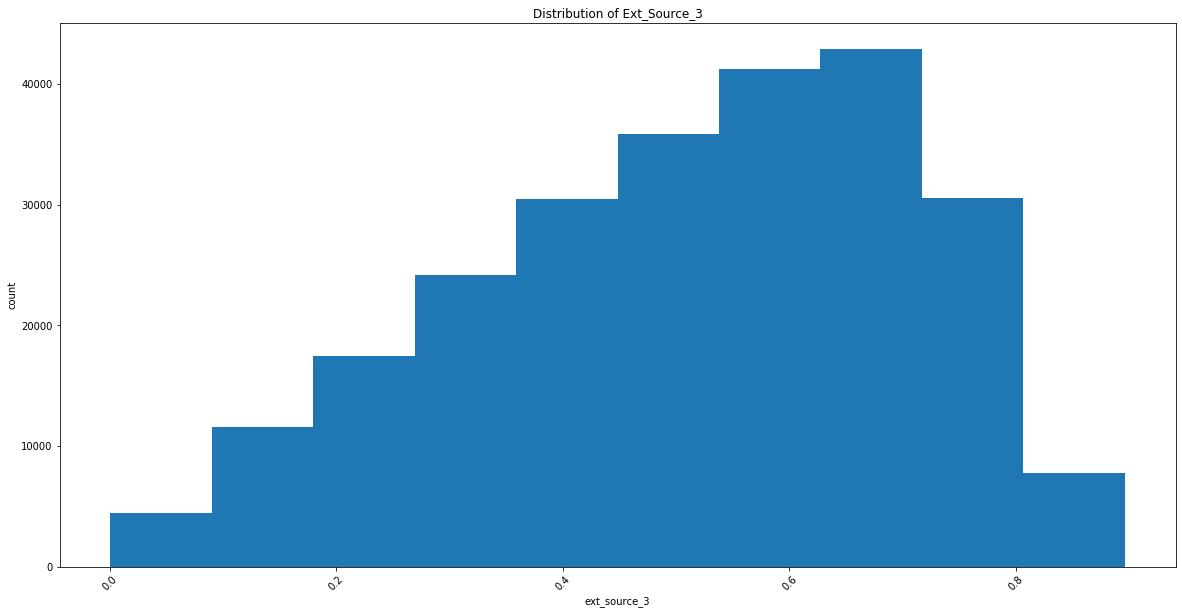

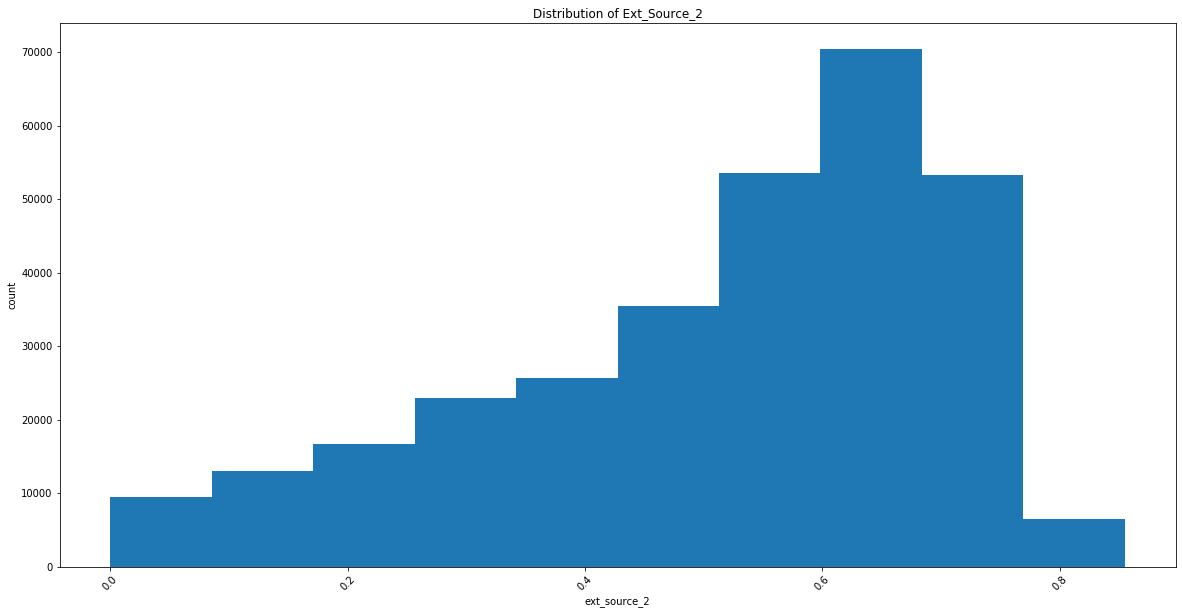

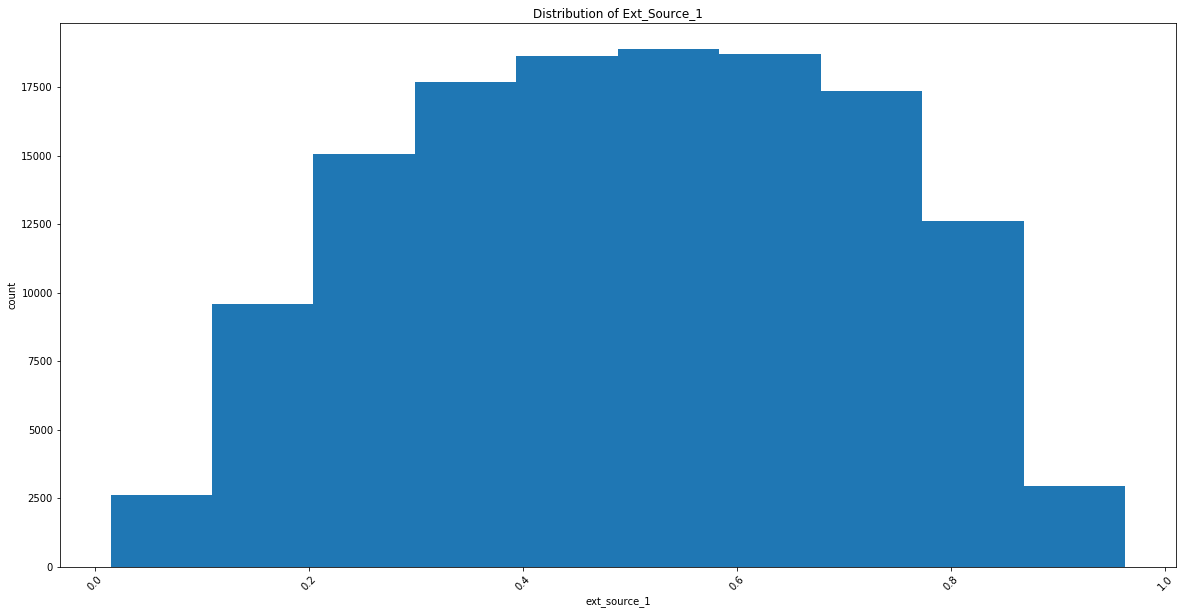

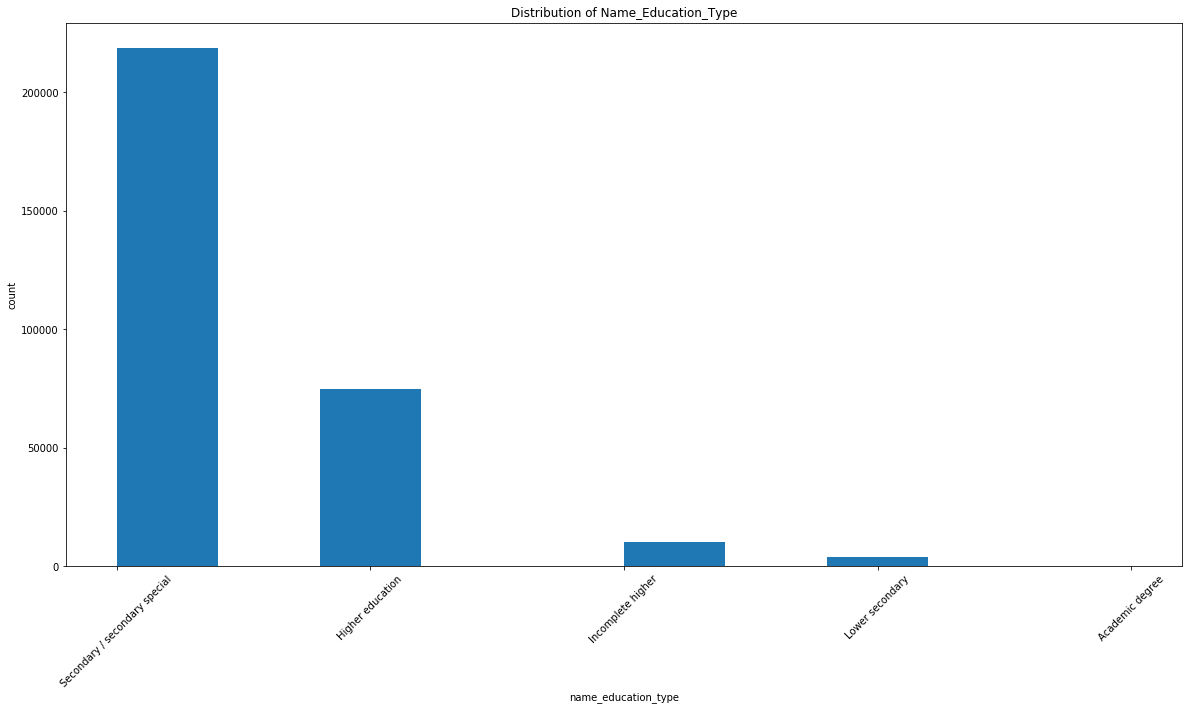

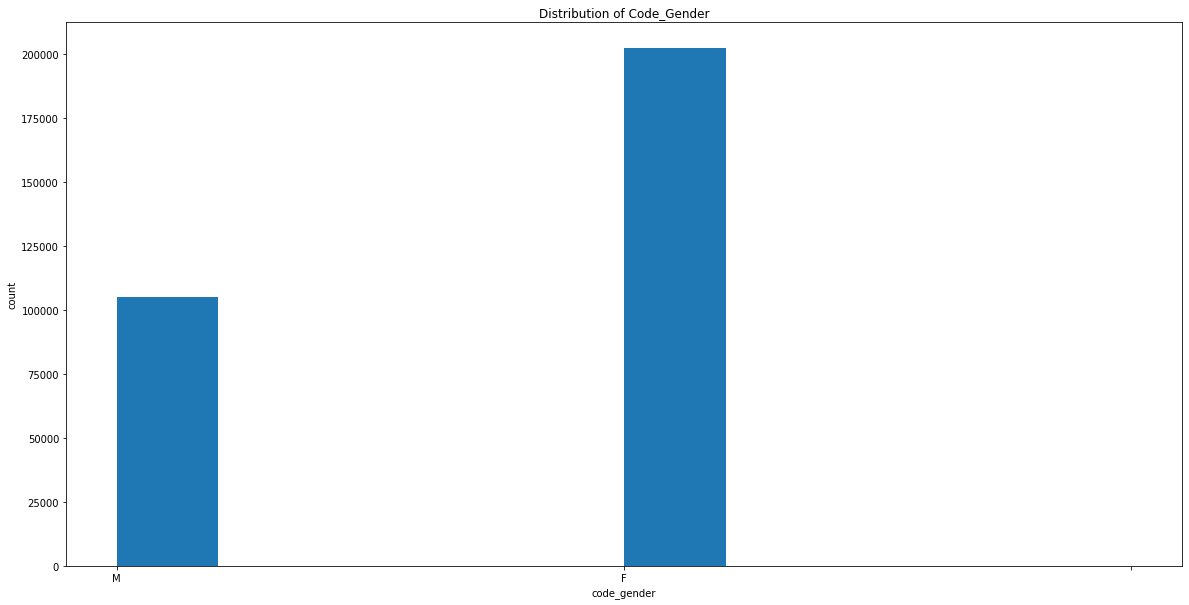

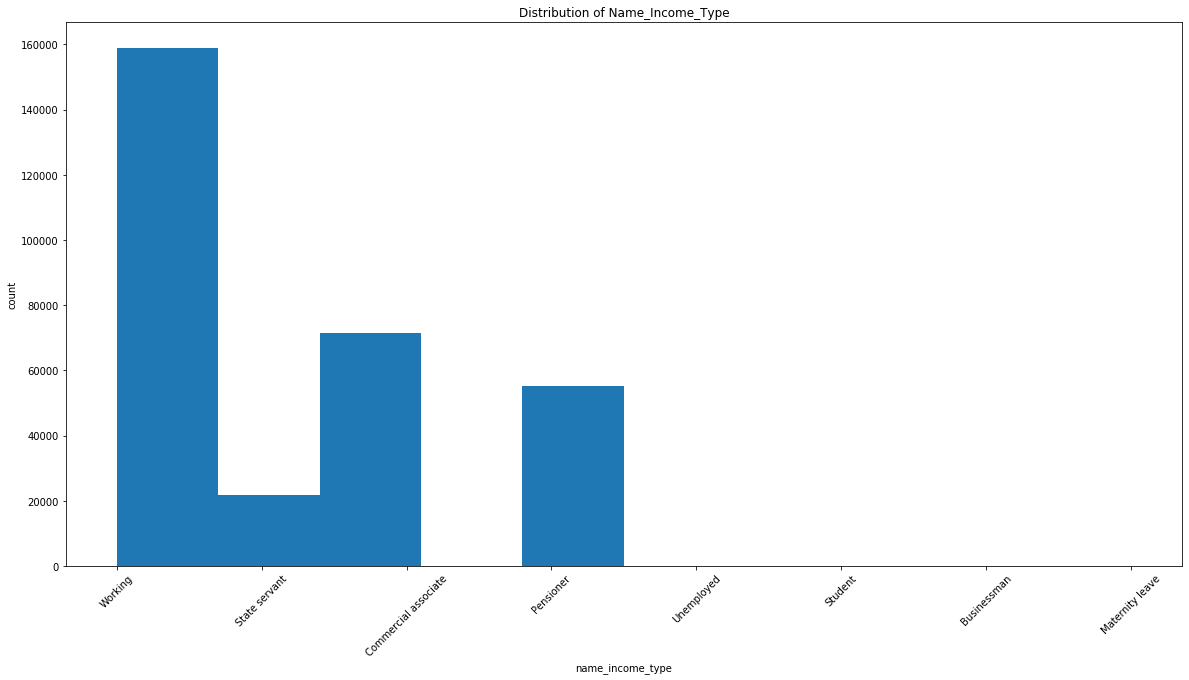

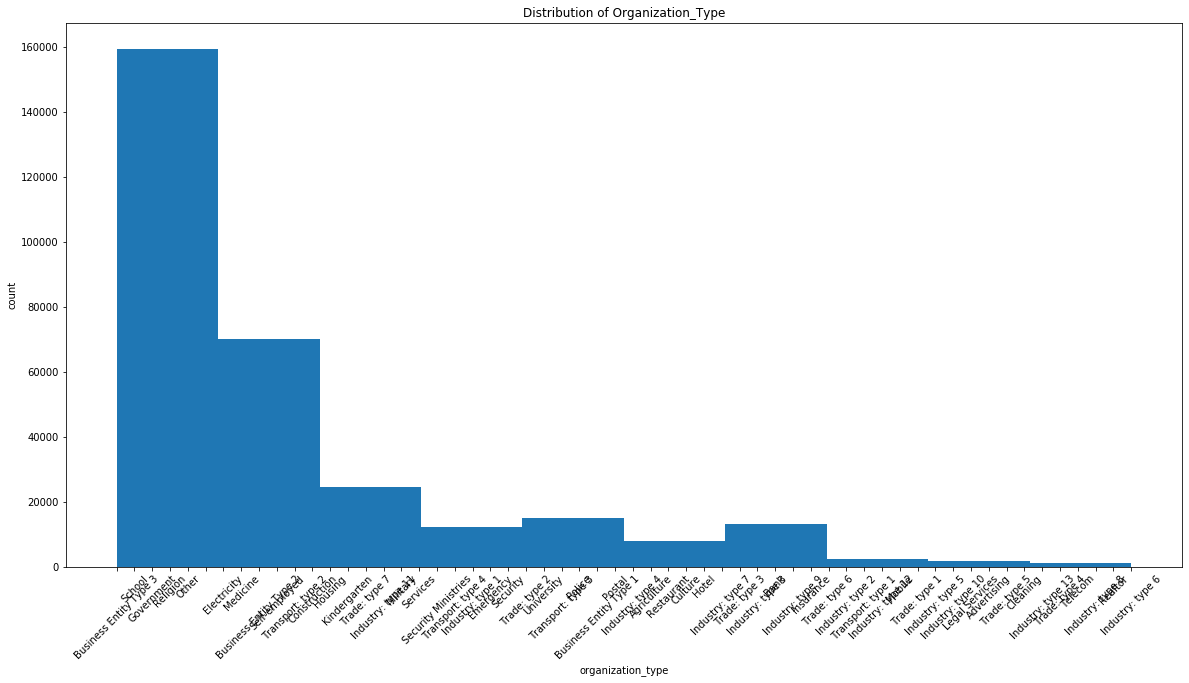

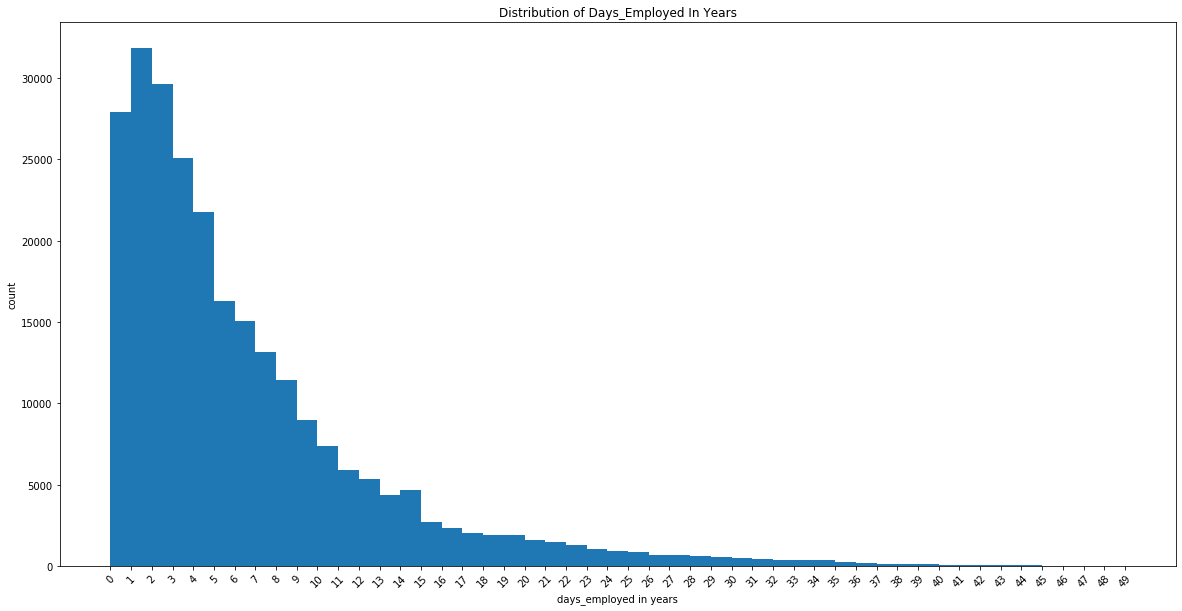

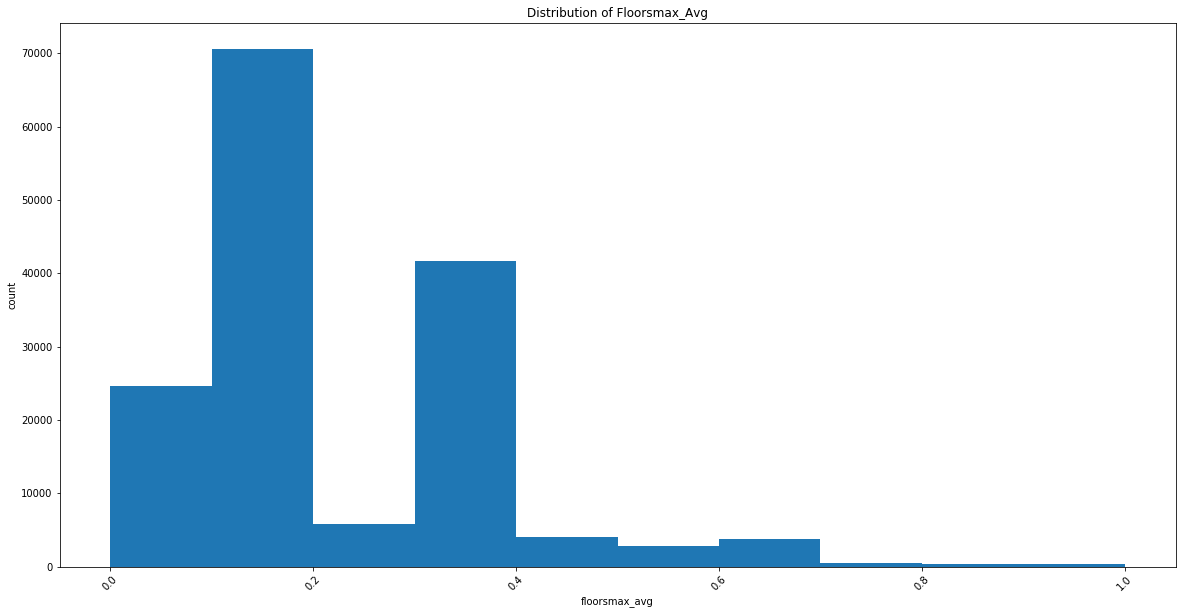

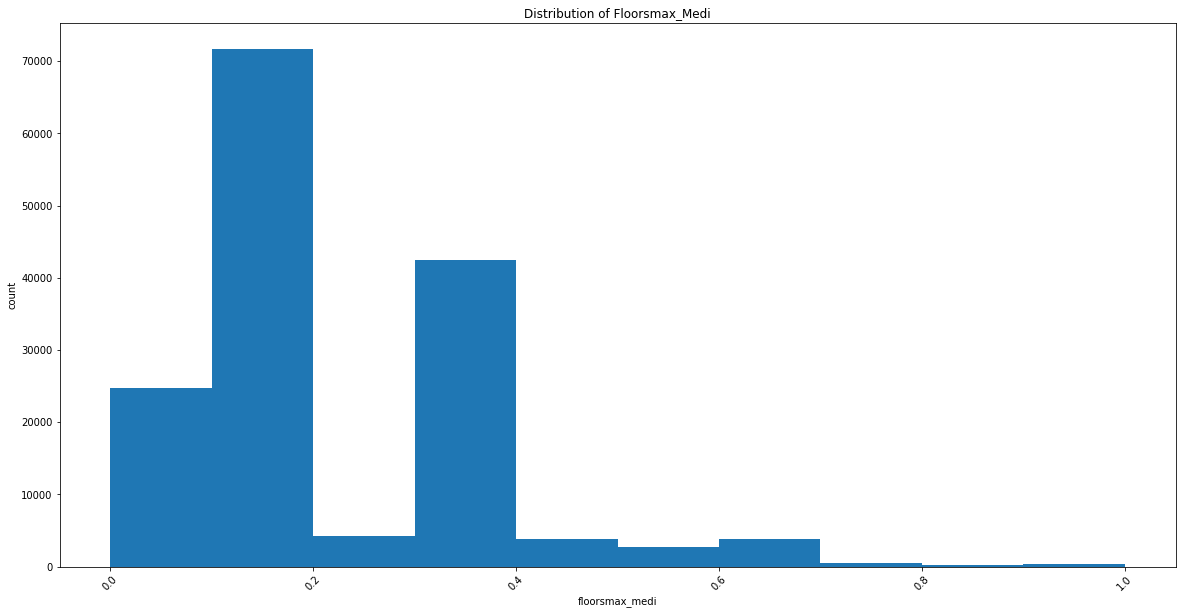

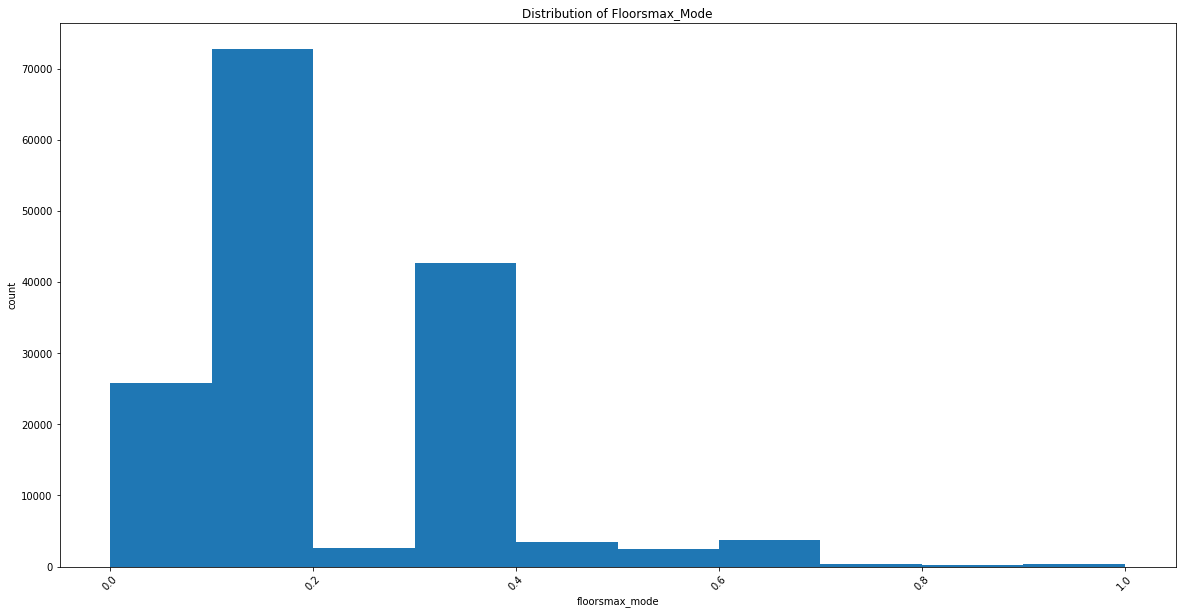

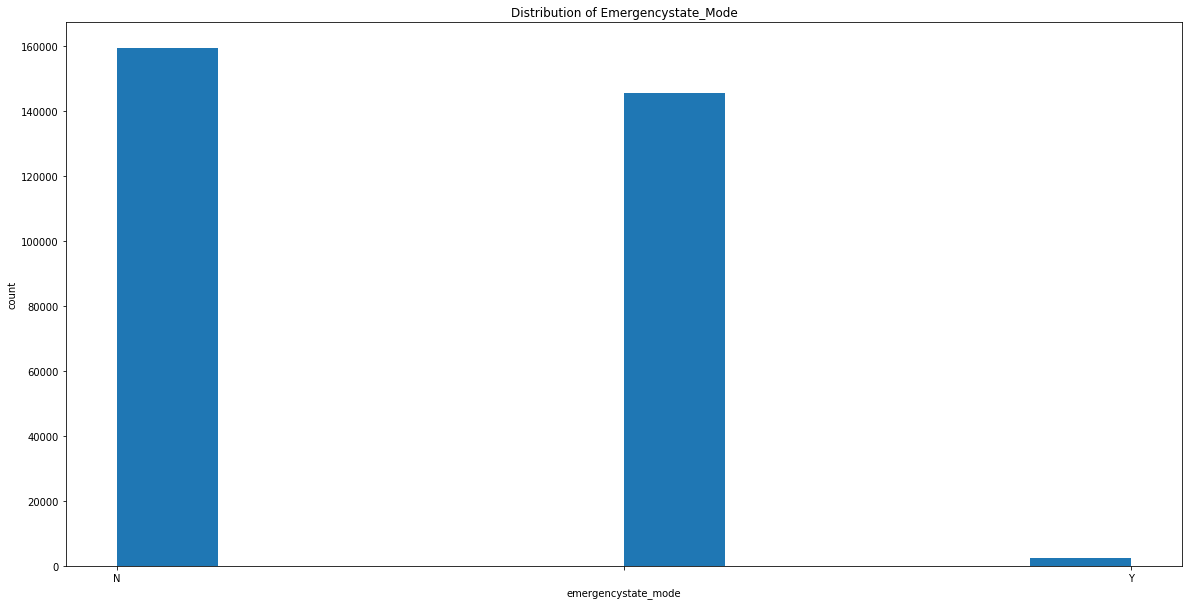

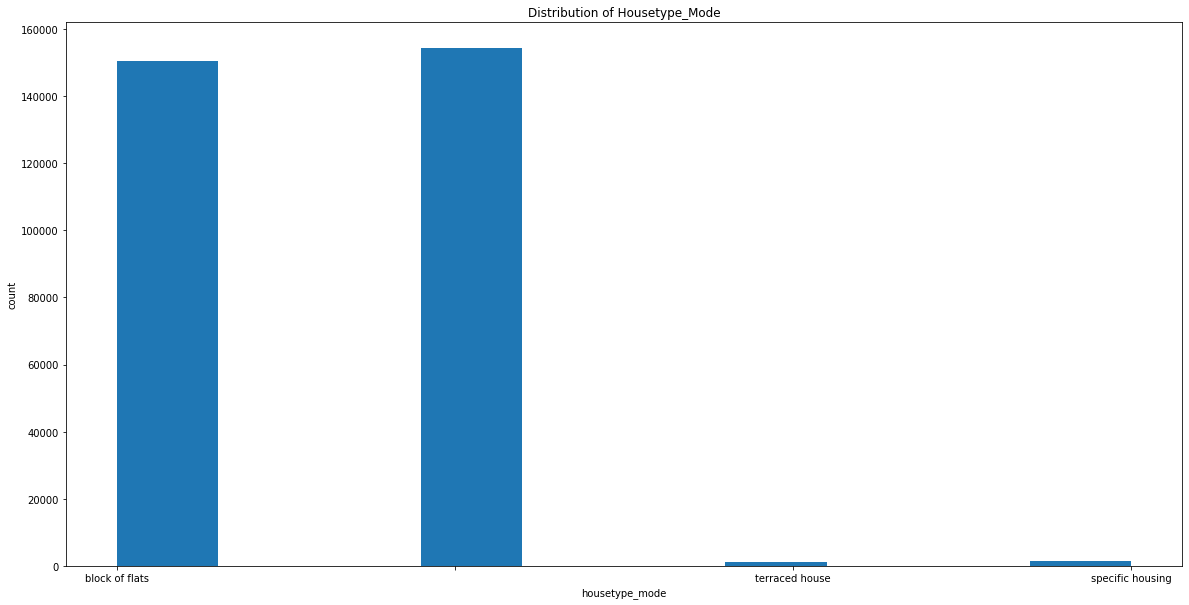

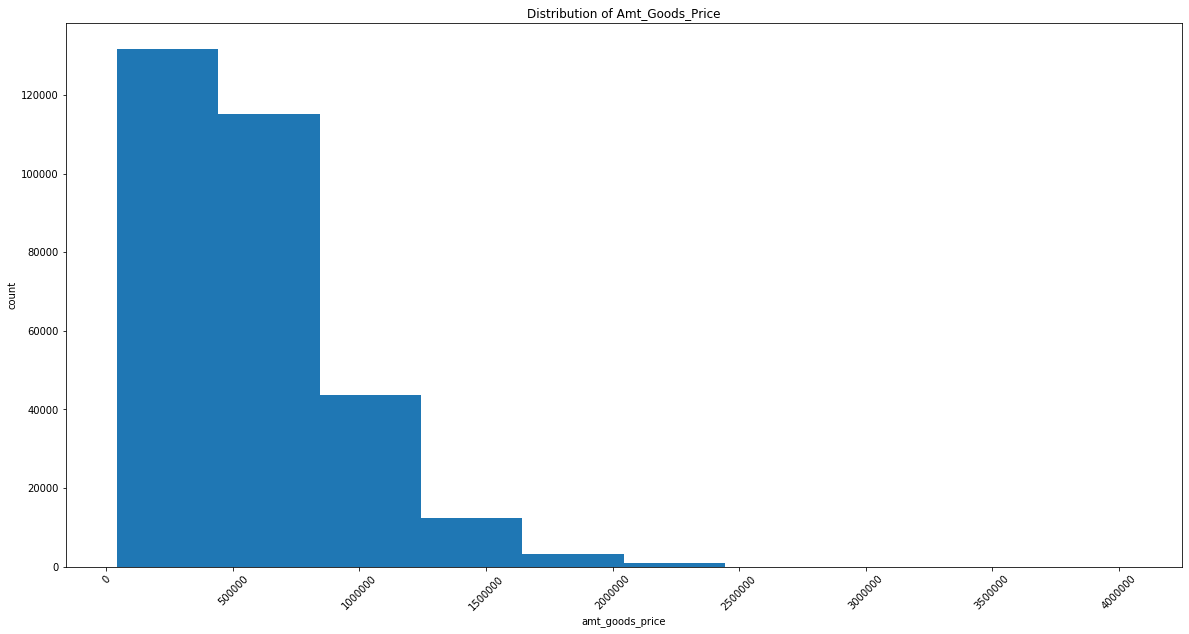

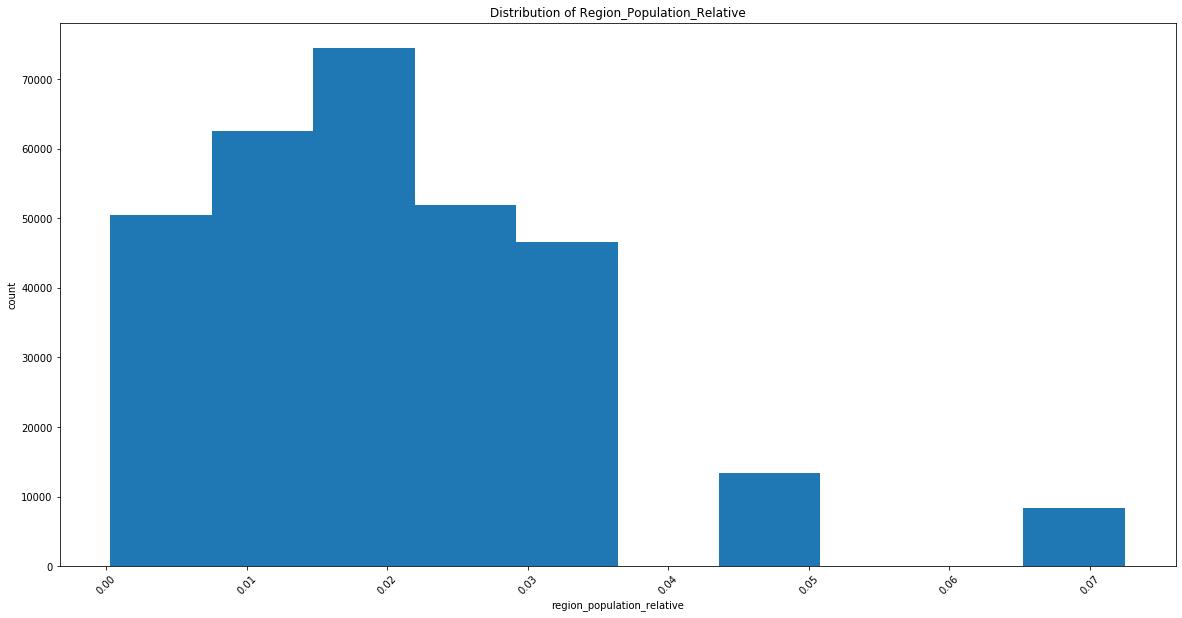

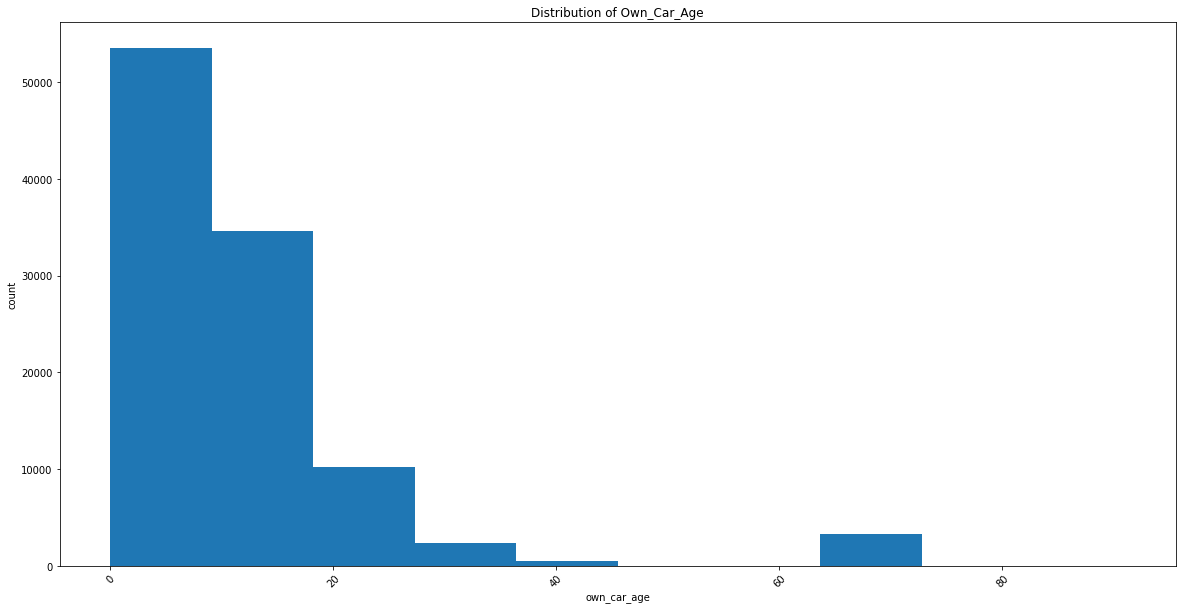

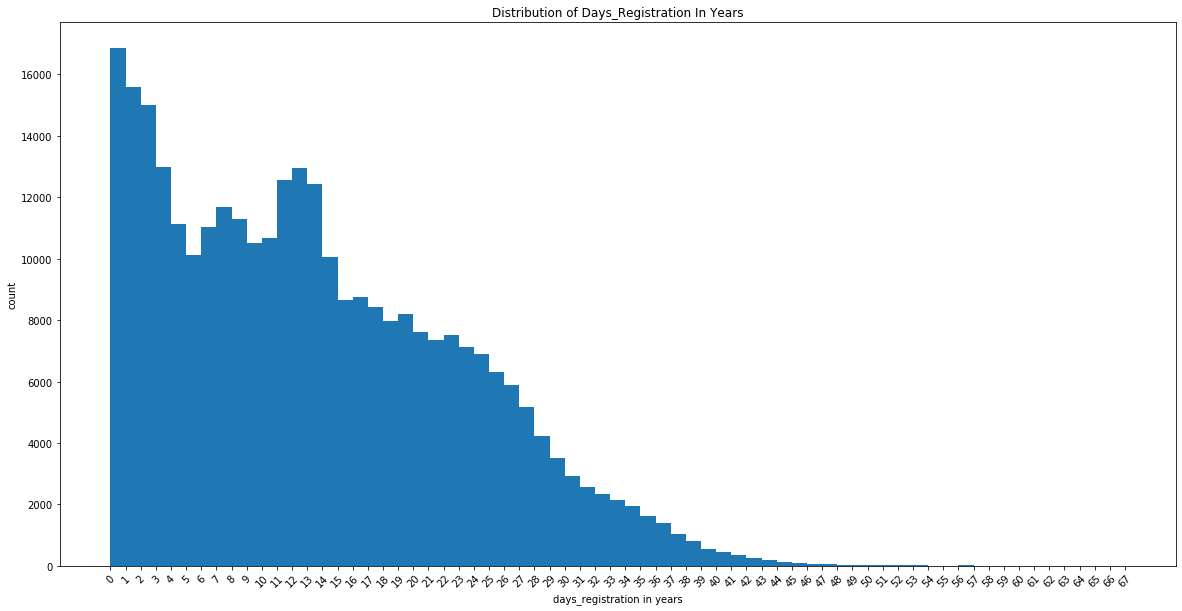

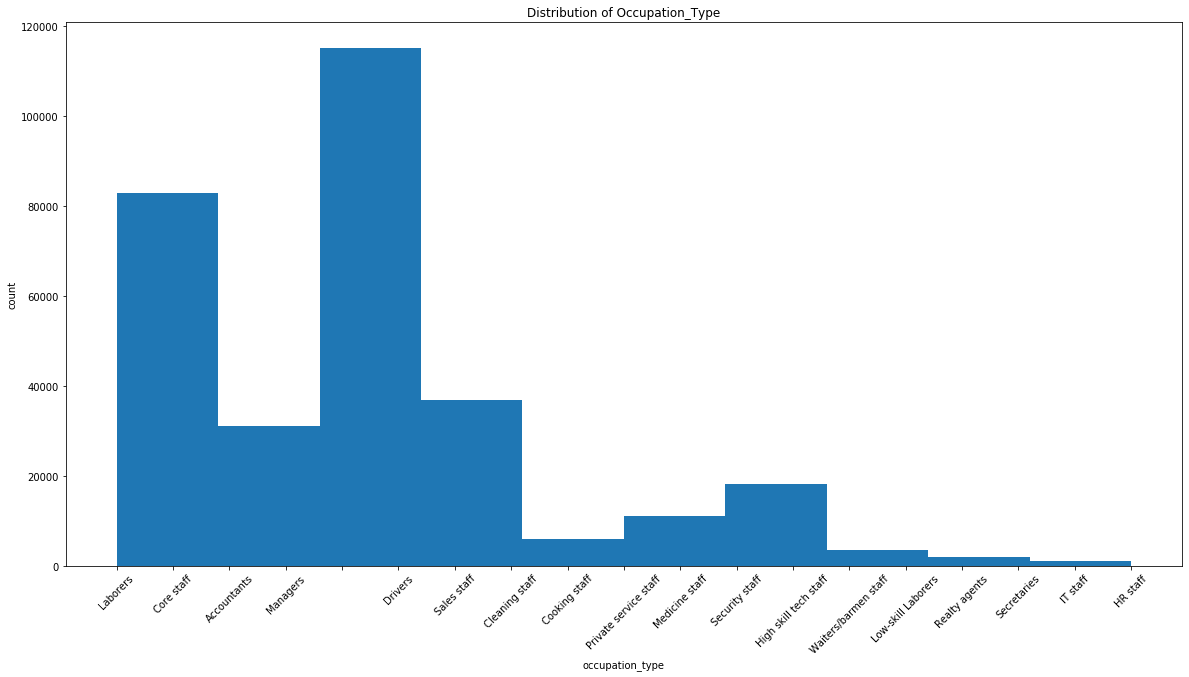

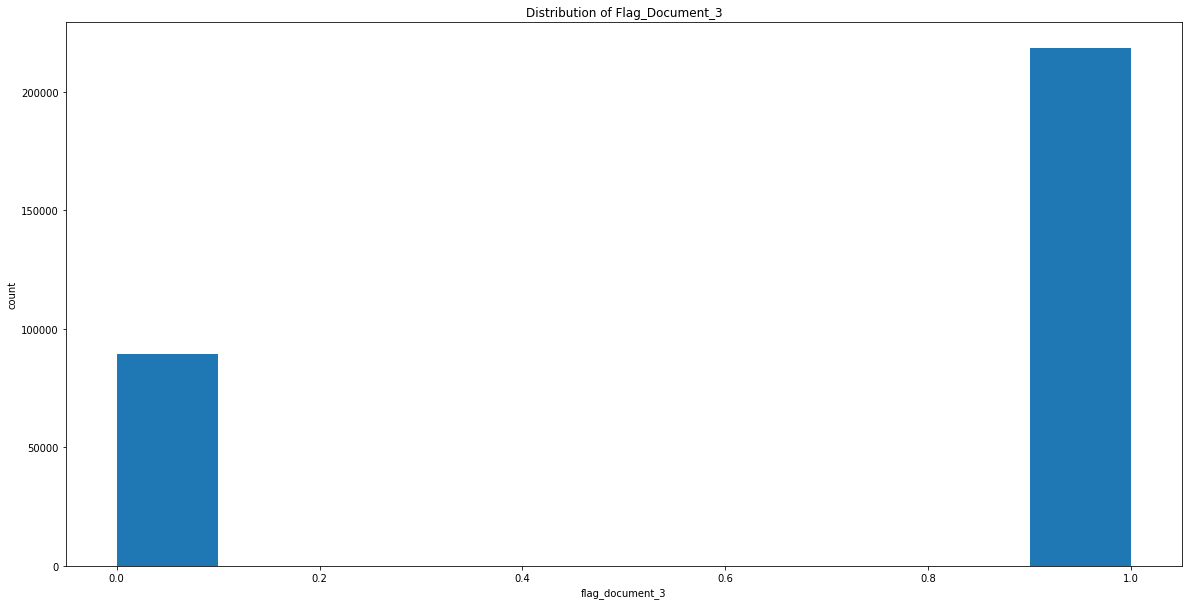

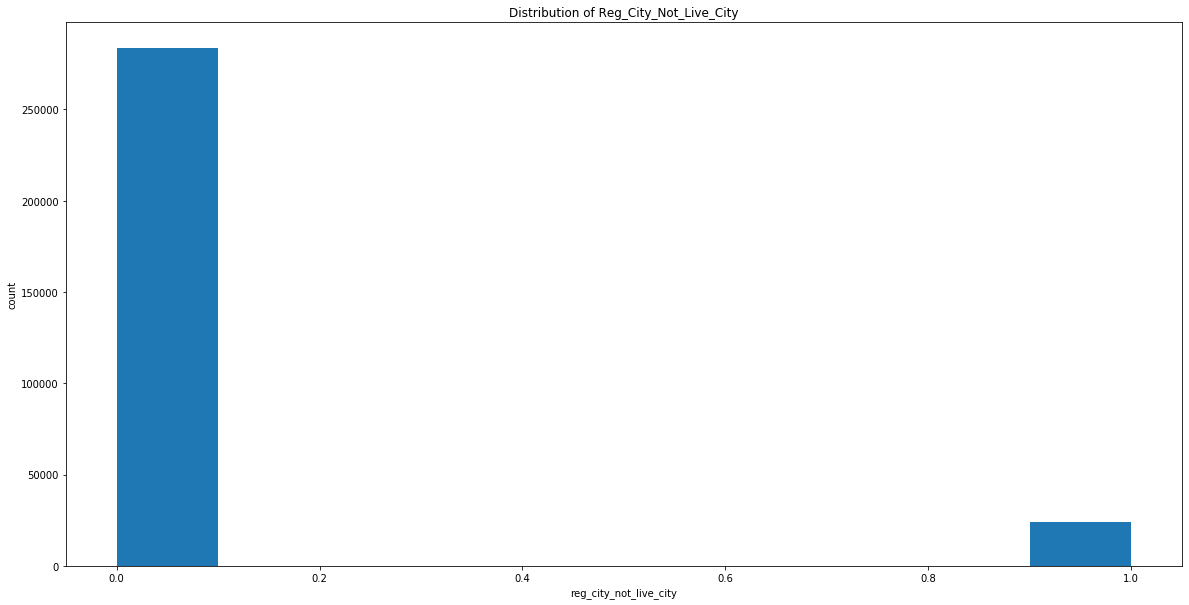

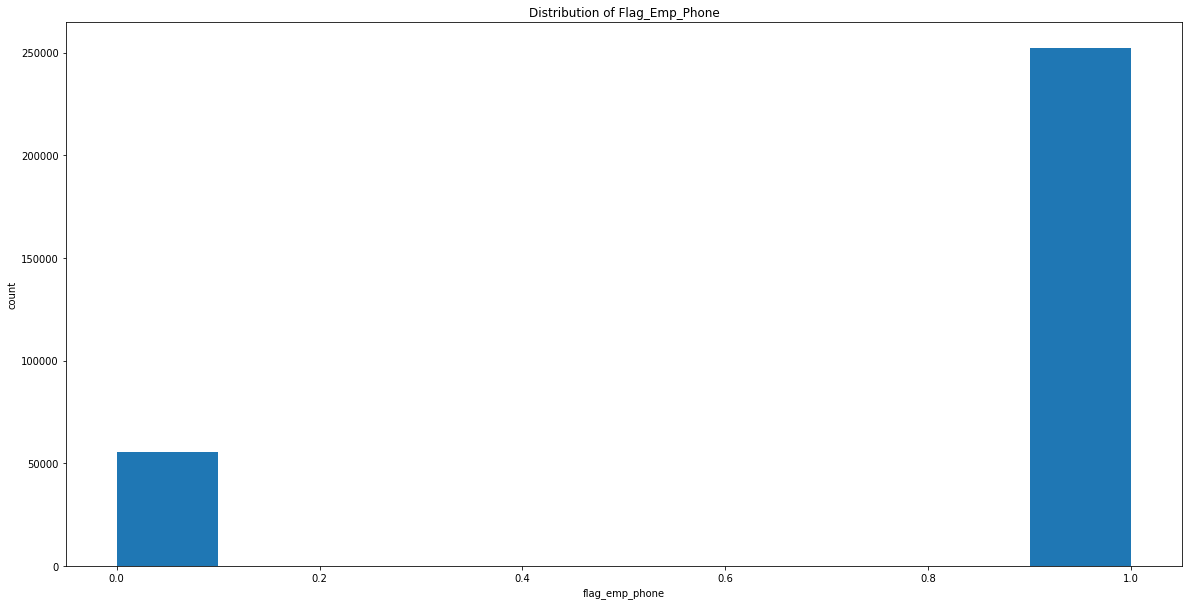

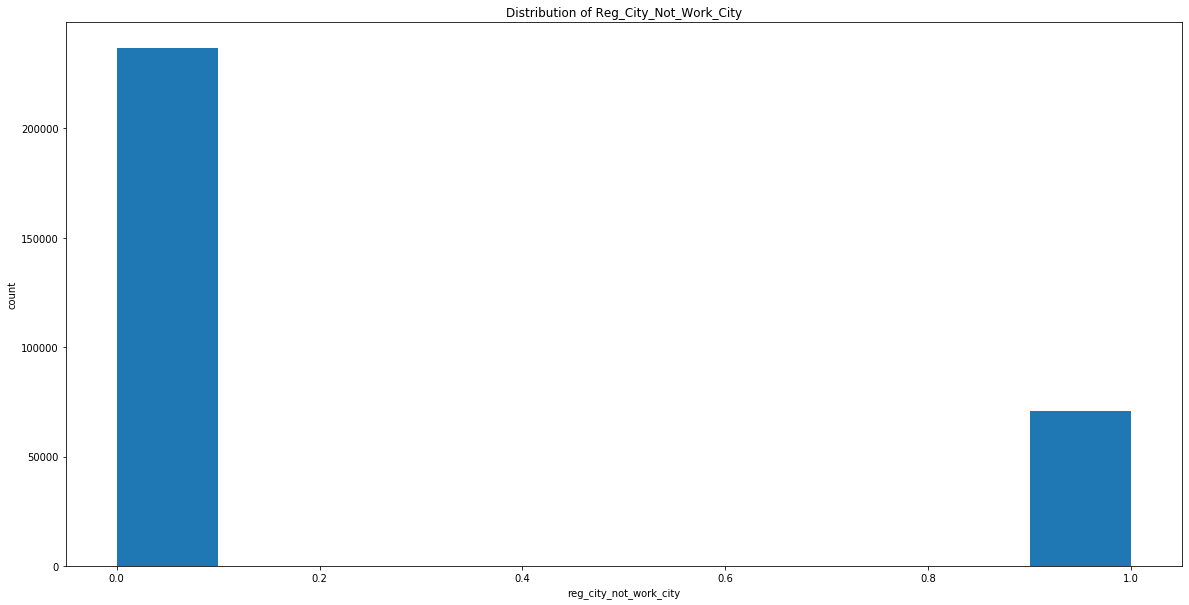

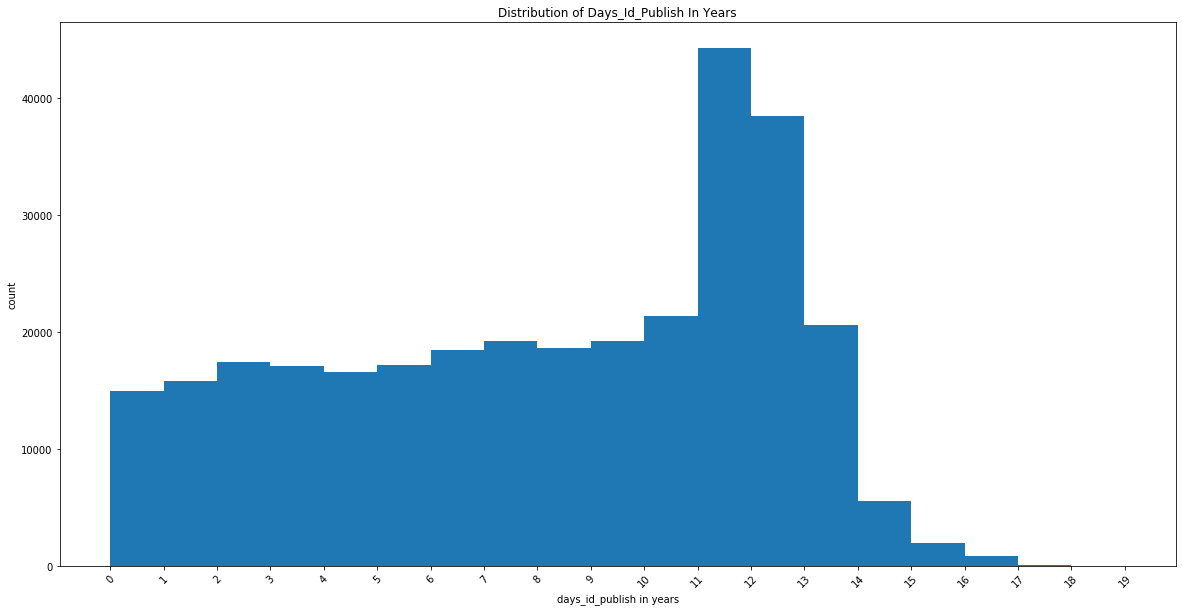

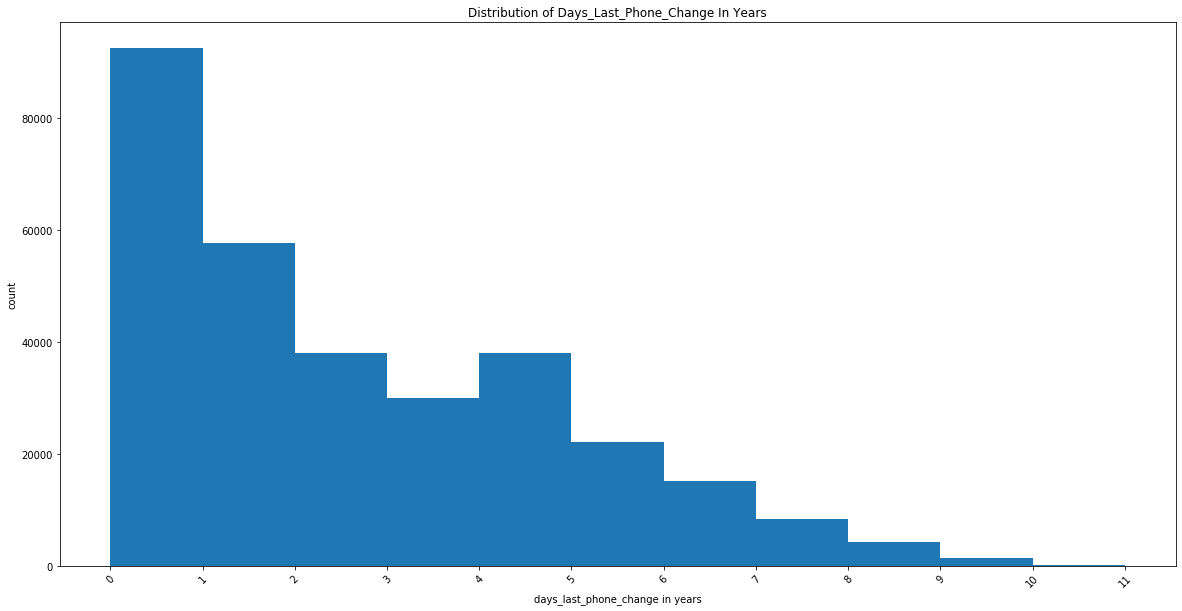

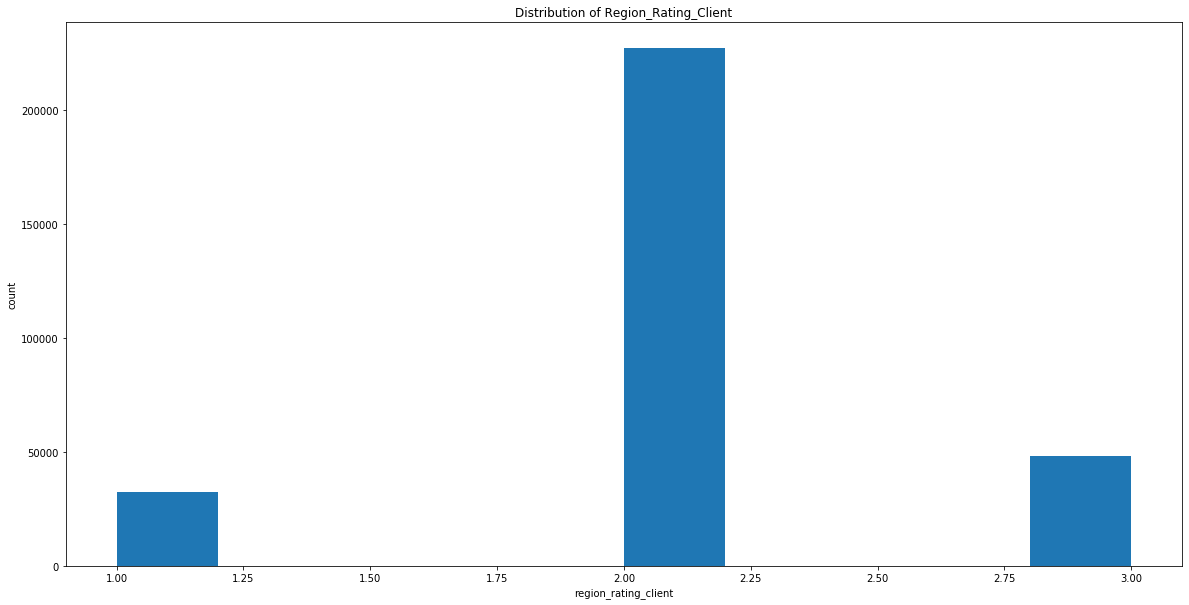

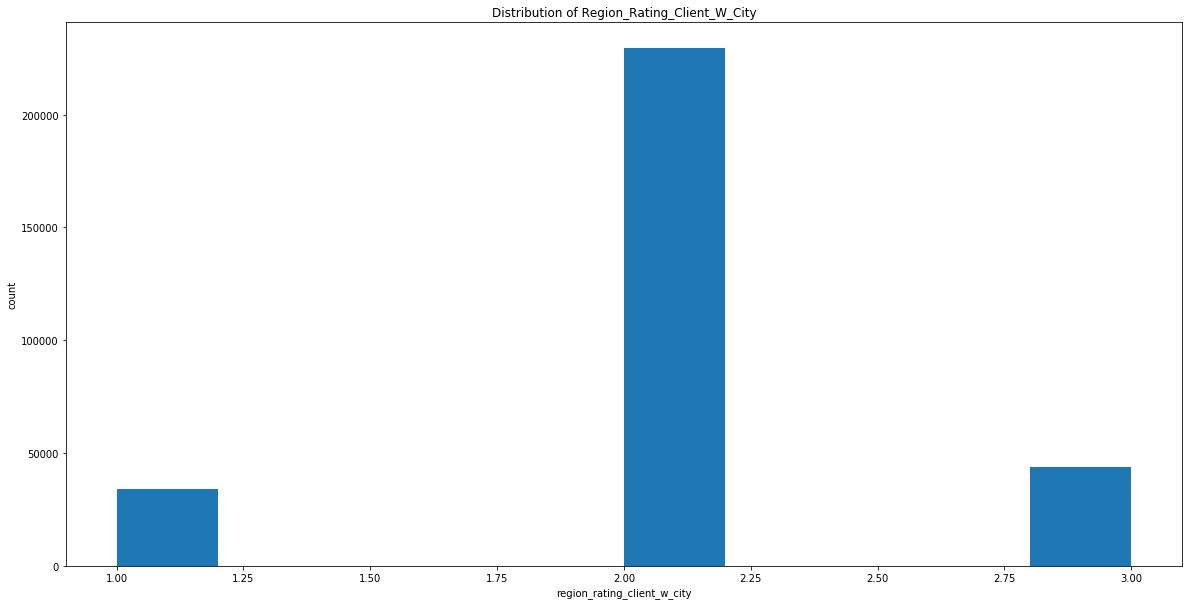

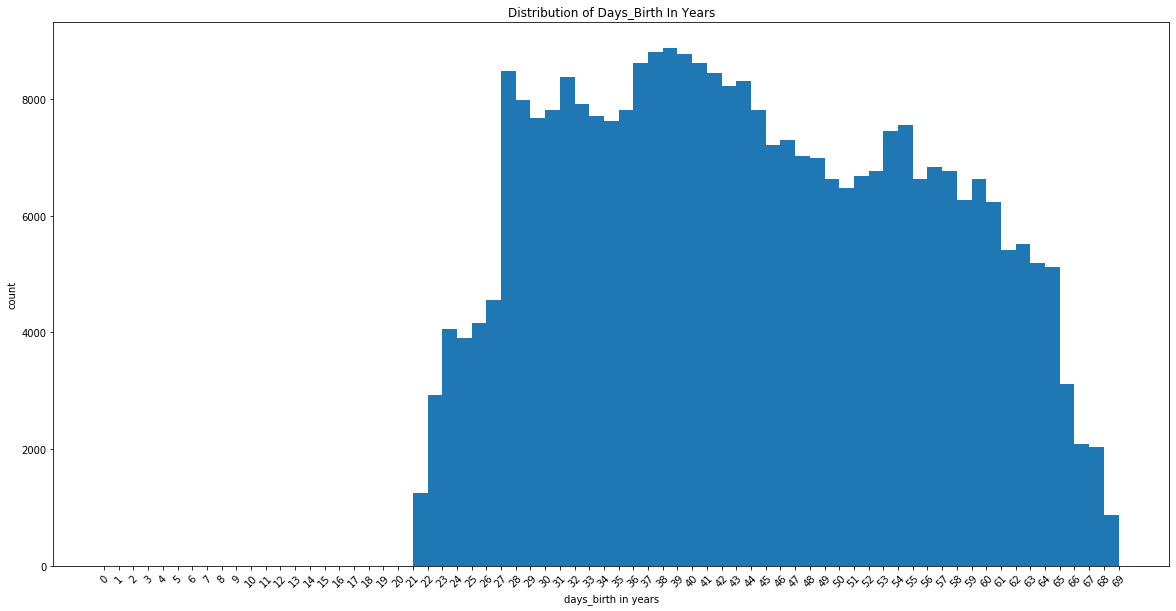

In [135]:
def plot_dist(df_in, col_list):
    
    df = df_in.copy()
    df = df[col_list]
    
    for col in df:
        plt.figure(figsize=(20,10))
        if 'days' in col:
            df[col] = df[col] / -365
            bins = np.arange(0, df[col].max(), 1)
            plt.hist(df[col], bins=bins)
            plt.xticks(bins)
            title = col.title() + ' In Years'
        else:
            plt.hist(df[col])
            title = col.title()
        plt.title('Distribution of {}'.format(title))
        plt.xlabel(title.lower())
        plt.ylabel('count')
        if len(df[col].unique()) > 4:
            plt.xticks(rotation=45)
        plt.savefig('C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/{}_hist.png'.format(col))
        plt.show()
        
        
plot_dist(train, ads_used_lower)

In [220]:
temp = train.copy()
for col in temp.columns:
    temp = temp[(temp[col].isnull() == False) & (temp[col2] != '')]
    
cat_vars = list(metrics[(metrics['dtype'] == 'object') & ((metrics['unique_vals'] > 3) | ((metrics['unique_vals'] == 3) & (metrics['missing_perc'] == 0)))]['column'])

for col in temp.columns:
    if col in list(metrics[(metrics['dtype'] == 'object')]['column']) and col not in cat_vars:
        unique_vals = list(temp[col].unique())
        temp[col] = np.where((temp[col] == unique_vals[0]), 0, 1)
        print('{} with {} coded as 0'.format(col, unique_vals[0]))
        
seen = []
corrs = pd.DataFrame()
for col1 in temp.columns:
    if col1 == 'target' or col1[-4:] == 'mode' or col1[-4:] == 'medi' or col1[-4:] == '_avg' or 'flag_document' in col1 or col1 in cat_vars:
        continue
    for col2 in temp.columns:
        if col1 == col2 or col2 + ', ' + col1 in seen or col2 in cat_vars or col2 == 'target':
            continue
        corr = np.corrcoef(temp[col1], temp[col2])[0,1]
        seen.append(col1 + ', ' + col2)
        corrs = corrs.append({'col1': col1, 'col2': col2, 'corr': corr}, ignore_index=True)

corrs_target = pd.DataFrame()
for col in temp.columns:
    if col not in cat_vars and col != 'target':
        corr = np.corrcoef(temp['target'], temp[col])[0,1]
        corrs_target = corrs_target.append({'col': col, 'corr': corr}, ignore_index=True)

name_contract_type with Cash loans coded as 0
code_gender with M coded as 0
flag_own_car with Y coded as 0
flag_own_realty with Y coded as 0
emergencystate_mode with N coded as 0


In [ ]:
corrs['abs_corr'] = abs(corrs['corr'])
corrs_target['abs_corr'] = abs(corrs_target['corr'])
dfi.export(corrs[abs(corrs['corr']) > 0.70].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/func_dependencies.png', max_rows=150)
dfi.export(corrs.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_nontarget.png', max_rows=150)
dfi.export(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_nonfunctional_nontarget.png', max_rows=150)
dfi.export(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_all_target.png', max_rows=150)
dfi.export(corrs_target[(abs(corrs['corr']) >= 0.03)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1).style.hide_index().set_table_styles([dict(selector = 'th', props=[('text-align', 'right')])]), 'C:/Users/bbloc/OneDrive/Desktop/NYU_Data_Science/Responsible_DS/Project/figures/correlations_large_target.png', max_rows=150)
display(corrs[abs(corrs['corr']) > 0.70])
display(corrs[(abs(corrs['corr']) > 0.15) & (abs(corrs['corr']) <= 0.70)].sort_values(by='abs_corr', ascending=False).drop(['abs_corr'], axis=1))
display(corrs_target.sort_values(by='abs_corr', ascending=False).drop(['abs_corr'],axis=1))
correlations = train.corr()['target'].sort_values()
correlations

In [130]:
col = 'occupation_type'
val = 'Laborers'
equal = True
print(len(train))
if equal:
    print(len(train[train[col] == val]))
    print('{:.1%}'.format(len(train[train[col] == val]) / len(train)))
else:
    print(len(train[train[col] >= val]))
    print('{:.1%}'.format(len(train[train[col] >= val]) / len(train)))
print(len(train[col].unique()))
# temp = train.copy()
# temp['count'] = temp.groupby(col)['sk_id_curr'].transform('count')
# temp.sort_values(by='count', ascending=False).drop_duplicates(col).head(10)[[col, 'count']]

307511
55186
17.9%
19


TypeError: unsupported operand type(s) for /: 'list' and 'int'